In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
#import libraries for model
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, BatchNormalization, AveragePooling2D, Dense, Conv2D , Flatten ,DepthwiseConv2D, ReLU ,GlobalAveragePooling2D , Dropout
import keras_tuner
from tensorflow import keras
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras import backend as K

In [3]:
#import libraries for preproccessing
import dlib
from PIL import Image
from PIL import ImageFilter
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as matimg
import os
import gc

# # Preparing Dataset

In [4]:
"""photo_size = 224
batch_size=32
def prepare_dataset(data_dir):
    datagen = ImageDataGenerator(
        rescale=1 / 255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2,
    )
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(photo_size,photo_size),
        class_mode='binary',
        batch_size=batch_size,
        classes=['non_autistic','autistic']
    )
    return generator

#load dataset
traindata = prepare_dataset("/kaggle/input/autistic-children-facial-data-set/train")
testdata= prepare_dataset("/kaggle/input/autistic-children-facial-data-set/test")
validData = prepare_dataset("/kaggle/input/autistic-children-facial-data-set/valid")"""

'photo_size = 224\nbatch_size=32\ndef prepare_dataset(data_dir):\n    datagen = ImageDataGenerator(\n        rescale=1 / 255,\n        rotation_range=40,\n        width_shift_range=.2,\n        height_shift_range=.2,\n        shear_range=.1,\n        horizontal_flip=True,\n        fill_mode=\'nearest\',\n        zoom_range=.2,\n    )\n    generator = datagen.flow_from_directory(\n        data_dir,\n        target_size=(photo_size,photo_size),\n        class_mode=\'binary\',\n        batch_size=batch_size,\n        classes=[\'non_autistic\',\'autistic\']\n    )\n    return generator\n\n#load dataset\ntraindata = prepare_dataset("/kaggle/input/autistic-children-facial-data-set/train")\ntestdata= prepare_dataset("/kaggle/input/autistic-children-facial-data-set/test")\nvalidData = prepare_dataset("/kaggle/input/autistic-children-facial-data-set/valid")'

# Load Dataset

In [5]:
train_data = "/kaggle/input/autism-image-data/AutismDataset/train"
test_data= "/kaggle/input/autism-image-data/AutismDataset/test"
valid_data_autistic = "/kaggle/input/autism-image-data/AutismDataset/valid/Autistic"
valid_data_nonautistic = "/kaggle/input/autism-image-data/AutismDataset/valid/Non_Autistic" 

In [6]:
train_img = ["/kaggle/input/autism-image-data/AutismDataset/train/{}".format(i) for i in os.listdir(train_data)]

test_img = ["/kaggle/input/autism-image-data/AutismDataset/test/{}".format(i) for i in os.listdir(test_data)]

valid_autistic_img = ["/kaggle/input/autism-image-data/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(valid_data_autistic)]
valid_nonautistic_img = ["/kaggle/input/autism-image-data/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(valid_data_nonautistic)] 

In [7]:
from pathlib import Path
def insert_str(string, str_to_insert, index):
    return string[:index] + str_to_insert + string[index:]

newpath = r'/kaggle/working/autism-image-data/AutismDataset/valid'
path = Path(newpath)
if path.is_dir() == False:
    os.makedirs(newpath)
for i in range(len(valid_autistic_img)):
    image = cv2.imread(valid_autistic_img[i])
    valid_autistic_img[i]=valid_autistic_img[i].replace('/Autistic','')
    valid_autistic_img[i]= insert_str(valid_autistic_img[i],"Autistic.",52)
    valid_autistic_img[i]= valid_autistic_img[i].split("/")[-1]
    cv2.imwrite ("/kaggle/working/autism-image-data/AutismDataset/valid/"+valid_autistic_img[i],image)
for i in range(len(valid_nonautistic_img)):
    image = cv2.imread(valid_nonautistic_img[i])
    valid_nonautistic_img[i]=valid_nonautistic_img[i].replace('/Non_Autistic','')
    valid_nonautistic_img[i]= insert_str(valid_nonautistic_img[i],"Non_Autistic.",52)
    valid_nonautistic_img[i]= valid_nonautistic_img[i].split("/")[-1]
    cv2.imwrite ("/kaggle/working/autism-image-data/AutismDataset/valid/"+valid_nonautistic_img[i],image)

In [8]:
valid_img = ["/kaggle/working/autism-image-data/AutismDataset/valid/{}".format(i) for i in os.listdir("/kaggle/working/autism-image-data/AutismDataset/valid")]

In [9]:
def encode_data (imagePath):
    x = []
    y = []
    for img_path in imagePath:
        img= img_path.split("/")[-1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if 'Autistic' in img:
            x.append(image)
            y.append(0)
        elif 'Non_Autistic' in img:
            x.append(image)
            y.append(1)
    return x , y

In [10]:
x_train , y_train = encode_data(train_img)
x_test , y_test = encode_data(test_img)
x_valid , y_valid = encode_data(valid_img)

# Preprocessing

In [11]:
def cropping_based_face_detection(samdata):
    detector = dlib.get_frontal_face_detector()
    greyimg=cv2.cvtColor(samdata, cv2.COLOR_BGR2GRAY)
    detectedimg = detector(greyimg)
    #print("found {} face(s)".format(len(detectedimg)))
    
    for face in detectedimg:
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        
        img=cv2.rectangle(samdata, (x1, y1), (x2, y2), (0, 0, 0), 2)
        img_height, img_width, c = img.shape
        samdata = img[max(0, face.top()): min(face.bottom(), img_height),max(0, face.left()): min(face.right(), img_width)]      
    return samdata   
for i in range(len(x_train)):
    x_train[i]=cropping_based_face_detection(x_train[i])
for i in range(len(x_valid)):
    x_valid[i]=cropping_based_face_detection(x_valid[i])
for i in range(len(x_test)):
    x_test[i]=cropping_based_face_detection(x_test[i])

In [12]:
def ReSize(detimg):
    img=cv2.resize(detimg,(224,224))
    return img

for i in range(len(x_train)):
    x_train[i]=ReSize(x_train[i])
for i in range(len(x_valid)):
    x_valid[i]=ReSize(x_valid[i])
for i in range(len(x_test)):
    x_test[i]=ReSize(x_test[i])

In [13]:
x_train = np.array([np.array(val) for val in x_train])
y_train = np.array([np.array(val) for val in y_train])
x_valid = np.array([np.array(val) for val in x_valid])
y_valid = np.array([np.array(val) for val in y_valid])
x_test = np.array([np.array(val) for val in x_test])
y_test = np.array([np.array(val) for val in y_test])

x_test = tf.cast(x_test , dtype=tf.float32)
y_test = tf.cast(y_test , dtype=tf.float32)
x_train = tf.cast(x_train , dtype=tf.float32)
y_train = tf.cast(y_train , dtype=tf.float32)
x_valid = tf.cast(x_valid , dtype=tf.float32)
y_valid = tf.cast(y_valid , dtype=tf.float32)

# pretrained mobileNetV1 Model

In [14]:
base_model=MobileNet(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation

17235968/17225924 [==============================] - 2s 0us/step


In [15]:
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers:
    layer.trainable=False

# Fit and Compile Model

In [16]:
def cal_steps(num_images, batch_size):
    # calculates steps for generator
    steps = num_images // batch_size
    # adds 1 to the generator steps if the steps multiplied by
    # the batch size is less than the total training samples
    return  steps

In [17]:
model.compile( optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['acc'])

#checkpoint = ModelCheckpoint("/kaggle/working/mobilenet_v1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False)
#early = EarlyStopping(monitor='val_acc',patience=30, verbose=1, mode='max')

#hist = model.fit(traindata, validation_data= validData, validation_steps=cal_steps(validData.samples, batch_size),epochs=50 ,steps_per_epoch=cal_steps(traindata.samples, batch_size))
hist = model.fit(x_train,y_train, validation_data= (x_valid,y_valid), validation_steps=cal_steps(len(x_valid), 32),epochs=50 ,steps_per_epoch=cal_steps(len(x_train), 32))
#tuner.search(x_train,y_train, validation_data= (x_valid,y_valid), validation_steps=cal_steps(len(x_valid), 32),epochs=50 ,steps_per_epoch=cal_steps(len(x_train), 32))

Epoch 1/50
79/79 [==============================] - 10s 39ms/step - loss: 0.9185 - acc: 0.0272 - val_loss: 0.9088 - val_acc: 0.0400
Epoch 2/50
79/79 [==============================] - 3s 35ms/step - loss: 0.9180 - acc: 0.0269 - val_loss: 0.9088 - val_acc: 0.0400
Epoch 3/50
79/79 [==============================] - 2s 30ms/step - loss: 0.9180 - acc: 0.0284 - val_loss: 0.9088 - val_acc: 0.0400
Epoch 4/50
79/79 [==============================] - 2s 30ms/step - loss: 0.9194 - acc: 0.0265 - val_loss: 0.9088 - val_acc: 0.0400
Epoch 5/50
79/79 [==============================] - 2s 30ms/step - loss: 0.9169 - acc: 0.0261 - val_loss: 0.9088 - val_acc: 0.0400
Epoch 6/50
79/79 [==============================] - 2s 30ms/step - loss: 0.9177 - acc: 0.0269 - val_loss: 0.9088 - val_acc: 0.0400
Epoch 7/50
79/79 [==============================] - 2s 30ms/step - loss: 0.9185 - acc: 0.0280 - val_loss: 0.9088 - val_acc: 0.0400
Epoch 8/50
79/79 [==============================] - 2s 30ms/step - loss: 0.9204 - 

In [18]:
#tuner.results_summary()

In [19]:
"""best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)"""

'best_hp = tuner.get_best_hyperparameters(1)[0]\nprint(best_hp.values)'

# Plotting History of Model

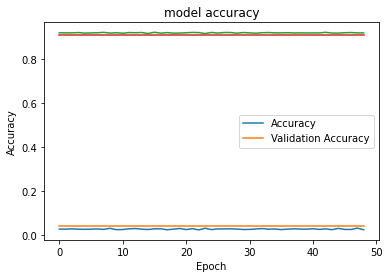

In [20]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

In [21]:
model.evaluate(x_valid,y_valid)

4/4 [==============================] - 0s 44ms/step - loss: 0.9088 - acc: 0.0400


[0.9087721109390259, 0.03999999910593033]

In [22]:
model.evaluate(x_train,y_train)

80/80 [==============================] - 2s 28ms/step - loss: 0.9182 - acc: 0.0272


[0.9182296395301819, 0.027165355160832405]

In [23]:
model.evaluate(x_test,y_test)

10/10 [==============================] - 0s 26ms/step - loss: 0.9262 - acc: 0.0167


[0.9262328147888184, 0.01666666753590107]